## Carga librerias

In [1]:
import pandas as pd
import numpy as np
import math
from scipy.stats import randint, uniform

# plots
import matplotlib.pyplot as plt
# %matplotlib inline
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import seaborn as sns

# misc
import time
import itertools
import warnings
warnings.filterwarnings("ignore")

# Summary stats
import skimpy as sk

### Import Models

In [2]:
# MODELS
from sklearn.metrics import root_mean_squared_error

# models
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Prophet
from prophet import Prophet
from prophet.plot import plot_cross_validation_metric, plot, plot_components
# Prophet evaluation
from prophet.diagnostics import cross_validation, performance_metrics

## Carga datos

In [3]:
from modules import load_data as m_ld

In [4]:
# Carga de diccionario
df = m_ld.load_data('sales_by_department_shop_with_events.csv')

display(df.head())

,fecha,ejercicio,mes,semana,store_code,category,department,unidades,cifra,region,store,latitud,longitud,event
0,2011-01-29,2011,1,4,BOS_1,ACCESORIES,ACCESORIES_1,241.0,951.95,Boston,South_End,42.3389,-71.0728,NaN
1,2011-01-29,2011,1,4,BOS_1,ACCESORIES,ACCESORIES_2,10.0,58.83,Boston,South_End,42.3389,-71.0728,NaN
2,2011-01-29,2011,1,4,BOS_1,HOME_&_GARDEN,HOME_&_GARDEN_1,418.0,1633.15,Boston,South_End,42.3389,-71.0728,NaN
3,2011-01-29,2011,1,4,BOS_1,HOME_&_GARDEN,HOME_&_GARDEN_2,106.0,712.49,Boston,South_End,42.3389,-71.0728,NaN
4,2011-01-29,2011,1,4,BOS_1,SUPERMARKET,SUPERMARKET_1,152.0,482.98,Boston,South_End,42.3389,-71.0728,NaN


# INFORME

In [5]:
# Convertimos 'fecha' a date
df['fecha'] = pd.to_datetime(df['fecha'], format = '%Y-%m-%d')

# Rellenamos events Nan con 'None'
df['event'] = df['event'].fillna(value='None')

# Aseguramos orden por fecha del df
df = df.sort_values('fecha',ascending=True)

# Encontrar la fecha mínima y máxima
min_date = df['fecha'].min()
max_date = df['fecha'].max()

# Calcular la diferencia en días
days_diff = (max_date - min_date).days + 1  # +1 para incluir ambos extremos

# Calcular la diferencia en meses
months_diff = round(days_diff / 30.5)  # Asumiendo un mes promedio de 30.5 días

print(f"Fecha mínima: {min_date}")
print(f"Fecha máxima: {max_date}")
print(f"Días de datos analizados: {days_diff}")
print(f"Meses de datos analizados: {months_diff}")
print(f"Fechas unicas que tenemos: {df['fecha'].nunique()}")
print(f"¿Faltan fechas?: {days_diff - df['fecha'].nunique()}")

Fecha mínima: 2011-01-29 00:00:00
Fecha máxima: 2016-04-24 00:00:00
Días de datos analizados: 1913
Meses de datos analizados: 63
Fechas unicas que tenemos: 1913
¿Faltan fechas?: 0


In [6]:
# Añadimos nombre del dia al df
df['dia'] = df['fecha'].dt.day_name()

# Vemos primer y último día
print(f'1er dia de nuestros datos: {df["dia"].iloc[0]}')
print(f'Ultimo dia de nuestros datos: {df["dia"].iloc[-1]}')

1er dia de nuestros datos: Saturday
Ultimo dia de nuestros datos: Sunday


In [7]:
# Añadimos numero de dia de la semana
df['dia_semana'] = df['fecha'].dt.dayofweek

In [8]:
# Skim describe
sk.skim(df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 133547 │ │ string      │ 7     │                                                          │
│ │ Number of columns │ 16     │ │ int32       │ 4     │                                                          │
│ └───────────────────┴────────┘ │ float64     │ 4     │                                                          │
│                                │ datetime64  │ 1     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name   ┃ NA  ┃ NA %  ┃ mean     ┃ sd      ┃ p0      ┃ p25     ┃ p50     ┃ p75    ┃ p100    ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━┩  │
│ │ ejercicio     │   0 │     0 │     2013 │   1.532 │    2011 │    2012 │    2013 │   2015 │    2016 │ ▇▇▇▇▇▃ │  │
│ │ mes           │   0 │     0 │    6.344 │   3.452 │       1 │       3 │       6 │      9 │      12 │ ▇▇▇▇▇▇ │  │
│ │ semana        │   0 │     0 │    25.81 │   15.09 │       1 │      12 │      25 │     39 │      53 │ ▇▇▆▇▇▆ │  │
│ │ unidades      │   0 │     0 │    491.9 │   602.9 │       1 │     136 │     287 │    551 │    5118 │   ▇▁   │  │
│ │ cifra         │   0 │     0 │     1730 │    1665 │    0.27 │   618.5 │    1230 │   2359 │   13440 │  ▇▂▁   │  │
│ │ latitud       │   0 │     0 │    40.98 │  0.9454 │   39.94 │   39.98 │   40.73 │  42.32 │   42.35 │ ▇▇▃  ▇ │  │
│ │ longitud      │   0 │     0 │   -73.46 │   1.631 │  -75.16 │  -75.15 │  -73.95 │  -71.1 │  -71.07 │ ▆▇   ▆ │  │
│ │ dia_semana    │   0 │     0 │    3.002 │   2.001 │       0 │       1 │       3 │      5 │       6 │ ▃▃▃▃▃▇ │  │
│ └───────────────┴─────┴───────┴──────────┴─────────┴─────────┴─────────┴─────────┴────────┴─────────┴────────┘  │
│                                                    datetime                                                     │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name            ┃ NA     ┃ NA %      ┃ first               ┃ last                ┃ frequency        ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩  │
│ │ fecha                  │      0 │         0 │     2011-01-29      │     2016-04-24      │ None             │  │
│ └────────────────────────┴────────┴───────────┴─────────────────────┴─────────────────────┴──────────────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name               ┃ NA      ┃ NA %       ┃ words per row                ┃ total words              ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ store_code                │       0 │          0 │                            1 │                   133547 │  │
│ │ category                  │       0 │          0 │  

# Time Series analisis

In [9]:
from modules import time_series_analisis as tma

In [13]:
# Obtenemos lista de regiones
store_code = df['region'].unique().tolist()

# Obtenemos lista de tiendas
store_code = df['store_code'].unique().tolist()

# Obtenemos lista de departamentos
department = df['department'].unique().tolist()

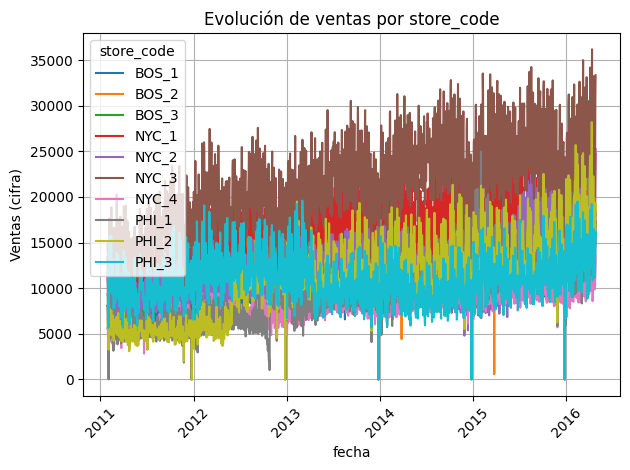

In [11]:
# Vemos graficas ventas por tiendas / regiones
tma.plot_sales(df, 'store_code')

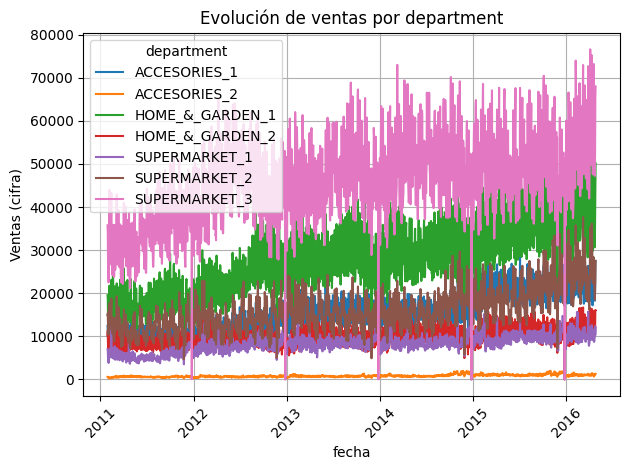

In [12]:
# Vemos graficas ventas por tiendas
tma.plot_sales(df, 'department')